In [827]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

## Pull CSV Files

In [717]:
zori = pd.read_csv('./data/cleandata/clean_zori.csv').drop('Unnamed: 0', axis = 1)
hpi = pd.read_csv('./data/cleandata/clean_hpi.csv').drop('Unnamed: 0', axis = 1)
zhvi = pd.read_csv('./data/cleandata/clean_zhvi.csv').drop('Unnamed: 0', axis = 1)
airq = pd.read_csv('./data/cleandata/clean_airq.csv').drop('Unnamed: 0', axis = 1)
population = pd.read_csv('./data/cleandata/clean_population.csv').drop('Unnamed: 0', axis = 1)
unemployment = pd.read_csv('./data/cleandata/clean_unemployment.csv').drop('Unnamed: 0', axis = 1)
education = pd.read_csv('./data/cleandata/clean_education.csv').drop('Unnamed: 0', axis = 1)
permits = pd.read_csv('./data/cleandata/clean_permits.csv').drop('Unnamed: 0', axis = 1)
IandH = pd.read_csv('./data/cleandata/clean_IandH.csv').drop('Unnamed: 0', axis = 1)
pce = pd.read_csv('./data/cleandata/clean_pce.csv').drop('Unnamed: 0', axis = 1)
vacancy = pd.read_csv('./data/cleandata/clean_vacancy.csv').drop('Unnamed: 0', axis = 1)
jobs = pd.read_csv('./data/cleandata/clean_jos.csv').drop('Unnamed: 0', axis = 1)
commute_worker = pd.read_csv('./data/cleandata/clean_commute_worker.csv').drop('Unnamed: 0', axis = 1)
grapi = pd.read_csv('./data/cleandata/clean_grapi.csv').drop('Unnamed: 0', axis = 1)

## Intermediate Matrices for Merging Dataframes before Training

In [699]:
one_year_forecast_train = zori[['Year', 'Month', 'Year_Month']]
one_year_forecast_train = pd.concat([one_year_forecast_train, 
                                     pd.DataFrame(one_year_forecast_train['Year'].map(lambda year: year - 1))], 
                                    axis = 1)
one_year_forecast_train.columns = ['Year', 'Month', 'Year_Month', 'Year2']
one_year_forecast_train = pd.concat([one_year_forecast_train, 
                                     pd.DataFrame(one_year_forecast_train['Year'].map(lambda year: year - 2))], 
                                    axis = 1)
one_year_forecast_train.columns = ['Year', 'Month', 'Year_Month', 'Year2', 'Year3']
one_year_forecast_train['Year_Month2'] = one_year_forecast_train['Year2'].map(str) + '_' +\
                                         one_year_forecast_train['Month'].map(str)
one_year_forecast_train['Year_Month3'] = one_year_forecast_train['Year3'].map(str) + '_' +\
                                         one_year_forecast_train['Month'].map(str)
one_year_forecast_train = one_year_forecast_train[['Year_Month', 'Year_Month2', 'Year_Month3']]
one_year_forecast_train.drop_duplicates(inplace = True)

In [700]:
one_year_forecast_train

,Year_Month,Year_Month2,Year_Month3
0,2014_2,2013_2,2012_2
1,2014_3,2013_3,2012_3
2,2014_4,2013_4,2012_4
3,2014_5,2013_5,2012_5
4,2014_6,2013_6,2012_6
...,...,...,...
75,2020_5,2019_5,2018_5
76,2020_6,2019_6,2018_6
77,2020_7,2019_7,2018_7
78,2020_8,2019_8,2018_8


## Final Dataframe for Training

In [701]:
df = zori[zori['ZORI'] <= 4000]
df = pd.merge(df, one_year_forecast_train, on = 'Year_Month')
df = pd.merge(df, zori[['Year_Month', 'ZipCode', 'ZORI']], left_on = ['Year_Month2', 'ZipCode'],
              right_on = ['Year_Month', 'ZipCode'], how = 'left')
df.drop('Year_Month_y', axis = 1, inplace = True)

In [702]:
df = pd.merge(df, zhvi[['Year_Month', 'ZipCode', 'ZHVI']], left_on = ['Year_Month2', 'ZipCode'],
              right_on = ['Year_Month', 'ZipCode'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [703]:
df = pd.merge(df, hpi[['Year_Month', 'ZipCode', 'HPI']], left_on = ['Year_Month3', 'ZipCode'],
              right_on = ['Year_Month', 'ZipCode'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [704]:
df = pd.merge(df, airq[['County', 'State', 'Year_Month', 'AQI']], left_on = ['County', 'State', 'Year_Month2'],
              right_on = ['County', 'State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [705]:
df = pd.merge(df, population[['County', 'State', 'Year_Month', 'Population']], 
              left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [706]:
df = pd.merge(df, unemployment[['County', 'State', 'Year_Month', 'Unemployment']], 
             left_on = ['County', 'State', 'Year_Month2'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [707]:
df = pd.merge(df, education[['County', 'State', 'Year_Month', 'Percent Bachelors']],
              left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [708]:
df = pd.merge(df, permits[['State', 'Units', 'Year_Month']], left_on = ['State', 'Year_Month2'], 
              right_on = ['State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [709]:
df = pd.merge(df, IandH[['County', 'State', 'Year_Month', 'Total_Households', 'Med_income']], 
             left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [710]:
df = pd.merge(df, pce[['PCE', 'Year_Month']], left_on = 'Year_Month2', right_on = 'Year_Month')
df.drop('Year_Month', axis = 1, inplace = True)

In [711]:
df = pd.merge(df, vacancy[['County', 'State', 'Year_Month', 'Rental Vacancy Rate']],
              left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [712]:
df = pd.merge(df, jobs[['State', 'Job Openings', 'Year_Month']], left_on = ['State', 'Year_Month2'], 
              right_on = ['State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [719]:
df = pd.merge(df, commute_worker[['County', 'State', 'CommuteTime', 'Salwrkr', 'Govwrkr', 'Year_Month']],
              left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [723]:
df = pd.merge(df, grapi[['County', 'State', 'GRAPI', 'Year_Month']], left_on = ['County', 'State', 'Year_Month3'], 
              right_on = ['County', 'State', 'Year_Month'], how = 'left')
df.drop('Year_Month', axis = 1, inplace = True)

In [725]:
df.columns

Index(['ZipCode', 'County', 'State', 'ZORI_x', 'Year', 'Month', 'Year_Month_x',
       'Year_Month2', 'Year_Month3', 'ZORI_y', 'ZHVI', 'HPI', 'AQI',
       'Population', 'Unemployment', 'Percent Bachelors', 'Units',
       'Total_Households', 'Med_income', 'PCE', 'Rental Vacancy Rate',
       'Job Openings', 'CommuteTime', 'Salwrkr', 'Govwrkr', 'GRAPI'],
      dtype='object')

In [726]:
df = df[['Year', 'Month', 'ZipCode', 'ZORI_x', 'ZORI_y', 'ZHVI', 'HPI', 'AQI', 'Population', 'Unemployment', 
         'Percent Bachelors', 'Units', 'Total_Households', 'Med_income', 'PCE', 'Rental Vacancy Rate', 'Job Openings', 
        'CommuteTime', 'Salwrkr', 'Govwrkr', 'GRAPI']]

In [727]:
df.columns = ['Year', 'Month', 'ZipCode', 'ZORI', 'ZORI_lagged_1', 'ZHVI_lagged_1', 'HPI_lagged_2', 'AQI_lagged_1',
              'Population_lagged_2', 'Unemployment_lagged_1', 'Percent Bachelors_lagged_2', 'Permits_lagged_1',
              'Total_Households_lagged_2', 'Med_Income_lagged_2', 'PCE_lagged_1', 'Rental Vacancy Rate_lagged_2',
              'Job Openings_lagged_1', 'CommuteTime_lagged_2', 'Salwrkr_lagged_2', 'Govwrkr_lagged_2', 'GRAPI_lagged_2']

In [728]:
# df_clean = df.drop('ZORI_lagged_1', axis = 1)
df_clean = df.copy()

In [729]:
df_clean.isnull().sum(axis = 0) 

Year                                0
Month                               0
ZipCode                             0
ZORI                                0
ZORI_lagged_1                   42156
ZHVI_lagged_1                   10148
HPI_lagged_2                    17192
AQI_lagged_1                    21794
Population_lagged_2              8690
Unemployment_lagged_1            7458
Percent Bachelors_lagged_2       8690
Permits_lagged_1                   80
Total_Households_lagged_2        8690
Med_Income_lagged_2              8690
PCE_lagged_1                        0
Rental Vacancy Rate_lagged_2     8943
Job Openings_lagged_1            1445
CommuteTime_lagged_2             8690
Salwrkr_lagged_2                 8690
Govwrkr_lagged_2                 8690
GRAPI_lagged_2                   8690
dtype: int64

In [730]:
# Dropping all NaN values because data is not available in certain zipcodes and counties
# These are missing data even after imputing. 
df_clean = df_clean[~df_clean['ZORI_lagged_1'].isnull()]
df_clean = df_clean[~df_clean['ZHVI_lagged_1'].isnull()]
df_clean = df_clean[~df_clean['HPI_lagged_2'].isnull()]
df_clean = df_clean[~df_clean['AQI_lagged_1'].isnull()]
df_clean = df_clean[~df_clean['Percent Bachelors_lagged_2'].isnull()]
df_clean = df_clean[~df_clean['Rental Vacancy Rate_lagged_2'].isnull()]

In [731]:
df_clean.isnull().sum(axis = 0) 

Year                            0
Month                           0
ZipCode                         0
ZORI                            0
ZORI_lagged_1                   0
ZHVI_lagged_1                   0
HPI_lagged_2                    0
AQI_lagged_1                    0
Population_lagged_2             0
Unemployment_lagged_1           0
Percent Bachelors_lagged_2      0
Permits_lagged_1                0
Total_Households_lagged_2       0
Med_Income_lagged_2             0
PCE_lagged_1                    0
Rental Vacancy Rate_lagged_2    0
Job Openings_lagged_1           0
CommuteTime_lagged_2            0
Salwrkr_lagged_2                0
Govwrkr_lagged_2                0
GRAPI_lagged_2                  0
dtype: int64

In [732]:
df_clean

,Year,Month,ZipCode,ZORI,ZORI_lagged_1,ZHVI_lagged_1,HPI_lagged_2,AQI_lagged_1,Population_lagged_2,Unemployment_lagged_1,...,Permits_lagged_1,Total_Households_lagged_2,Med_Income_lagged_2,PCE_lagged_1,Rental Vacancy Rate_lagged_2,Job Openings_lagged_1,CommuteTime_lagged_2,Salwrkr_lagged_2,Govwrkr_lagged_2,GRAPI_lagged_2
33517,2015,2,60657,1643.0,1583.0,441010.0,147.81,59.571429,5240700.0,9.1,...,269.0,1939894.0,53827.0,1.455676,6.2,154.0,31.9,84.1,11.1,1468.8
33520,2015,2,60614,1808.0,1752.0,564138.0,134.51,59.571429,5240700.0,9.1,...,269.0,1939894.0,53827.0,1.455676,6.2,154.0,31.9,84.1,11.1,1468.8
33521,2015,2,77449,1361.0,1288.0,137129.0,119.96,50.571429,4336853.0,5.5,...,4368.0,1497363.0,52489.0,1.455676,8.2,374.0,28.1,83.7,9.8,1230.3
33523,2015,2,77084,1214.0,1123.0,136900.0,119.39,50.571429,4336853.0,5.5,...,4368.0,1497363.0,52489.0,1.455676,8.2,374.0,28.1,83.7,9.8,1230.3
33524,2015,2,79936,977.0,992.0,118388.0,141.34,42.571429,827718.0,7.0,...,4368.0,258587.0,39945.0,1.455676,8.5,374.0,23.0,72.7,20.4,234.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247032,2020,9,92624,2897.0,3029.0,1050005.0,245.57,58.000000,3185968.0,2.5,...,5364.0,1040394.0,89759.0,1.721905,4.0,777.0,28.3,81.6,10.1,2.1
247033,2020,9,32266,2150.0,2098.0,455807.0,238.65,46.346154,950181.0,3.0,...,6613.0,367238.0,55832.0,1.721905,5.9,431.0,25.5,85.2,10.9,1.9
247035,2020,9,30288,1253.0,1140.0,134851.0,90.63,46.200000,289615.0,3.8,...,1059.0,96286.0,46646.0,1.721905,9.4,229.0,33.2,81.9,14.2,2.1
247037,2020,9,2466,2164.0,2162.0,960437.0,228.58,34.066667,1614714.0,2.2,...,371.0,612224.0,100517.0,1.721905,2.8,173.0,32.0,83.4,10.5,1.7


In [733]:
train_idx = np.random.choice(range(df_clean.shape[0]), round(df_clean.shape[0] * 0.75), replace = False)

In [734]:
train = df_clean.iloc[train_idx, :]
test = df_clean.iloc[list(set(range(df_clean.shape[0])) - set(train_idx)), :]

## Intermediate Matrices for Merging Dataframes before Predicting

In [735]:
prediction_start_month = 10
prediction_start_year = 2020
prediction_horizon_months = 12

In [736]:
one_year_forecast_pred = pd.DataFrame({'Year': np.array(prediction_start_year).repeat(prediction_horizon_months), 
                                       'Month': np.arange(prediction_start_month, 
                                                          prediction_start_month + prediction_horizon_months)})
one_year_forecast_pred['Year_Month'] = one_year_forecast_pred['Year'].map(str) + '_' +\
                                       one_year_forecast_pred['Month'].map(str)
one_year_forecast_pred['Year_Month'] = one_year_forecast_pred['Year_Month'].map(lambda x: str(int(x[:4]) + 1) + '_' +\
                                                                                str(int(x[x.find('_') + 1:]) - 12) if \
                                                                                int(x[x.find('_') + 1:]) > 12 else x)
one_year_forecast_pred['Year'] = one_year_forecast_pred['Year_Month'].map(lambda x: int(x[:4]))
one_year_forecast_pred['Month'] = one_year_forecast_pred['Year_Month'].map(lambda x: int(x[x.find('_') + 1:]))
one_year_forecast_pred = pd.concat([one_year_forecast_pred, 
                                    pd.DataFrame(one_year_forecast_pred['Year'].map(lambda year: year - 1))], 
                                   axis = 1)
one_year_forecast_pred.columns = ['Year', 'Month', 'Year_Month', 'Year2']
one_year_forecast_pred = pd.concat([one_year_forecast_pred, 
                                    pd.DataFrame(one_year_forecast_pred['Year'].map(lambda year: year - 2))], 
                                   axis = 1)
one_year_forecast_pred.columns = ['Year', 'Month', 'Year_Month', 'Year2', 'Year3']
one_year_forecast_pred['Year_Month2'] = one_year_forecast_pred['Year2'].map(str) + '_' +\
                                        one_year_forecast_pred['Month'].map(str)
one_year_forecast_pred['Year_Month3'] = one_year_forecast_pred['Year3'].map(str) + '_' +\
                                        one_year_forecast_pred['Month'].map(str)
one_year_forecast_pred = one_year_forecast_pred[['Year_Month', 'Year_Month2', 'Year_Month3']]

In [737]:
one_year_forecast_pred

,Year_Month,Year_Month2,Year_Month3
0,2020_10,2019_10,2018_10
1,2020_11,2019_11,2018_11
2,2020_12,2019_12,2018_12
3,2021_1,2020_1,2019_1
4,2021_2,2020_2,2019_2
5,2021_3,2020_3,2019_3
6,2021_4,2020_4,2019_4
7,2021_5,2020_5,2019_5
8,2021_6,2020_6,2019_6
9,2021_7,2020_7,2019_7


## Final DataFrame for Prediction

In [738]:
df_pred = zori.copy()
df_pred = pd.merge(df_pred, one_year_forecast_pred, left_on = 'Year_Month', right_on = 'Year_Month2')
df_pred.drop('Year_Month_x', axis = 1, inplace = True)
df_pred['Year'] = df_pred['Year'] + 1

In [739]:
df_pred = pd.merge(df_pred, zhvi[['Year_Month', 'ZipCode', 'ZHVI']], left_on = ['Year_Month2', 'ZipCode'],
                   right_on = ['Year_Month', 'ZipCode'], how = 'left')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [740]:
df_pred = pd.merge(df_pred, hpi[['Year_Month', 'ZipCode', 'HPI']], left_on = ['Year_Month3', 'ZipCode'],
                   right_on = ['Year_Month', 'ZipCode'], how = 'left')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [741]:
df_pred = pd.merge(df_pred, airq[['County', 'State', 'Year_Month', 'AQI']], left_on = ['County', 'State', 'Year_Month2'],
                   right_on = ['County', 'State', 'Year_Month'], how = 'left')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [742]:
df_pred = pd.merge(df_pred, population[['County', 'State', 'Year_Month', 'Population']], 
                   left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [743]:
df_pred = pd.merge(df_pred, unemployment[['County', 'State', 'Year_Month', 'Unemployment']], 
                   left_on = ['County', 'State', 'Year_Month2'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [744]:
df_pred = pd.merge(df_pred, education[['County', 'State', 'Year_Month', 'Percent Bachelors']],
                   left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [745]:
df_pred = pd.merge(df_pred, permits[['State', 'Units', 'Year_Month']], left_on = ['State', 'Year_Month2'], 
                   right_on = ['State', 'Year_Month'], how = 'left')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [746]:
df_pred = pd.merge(df_pred, IandH[['County', 'State', 'Year_Month', 'Total_Households', 'Med_income']], 
                   left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [747]:
df_pred = pd.merge(df_pred, pce[['PCE', 'Year_Month']], left_on = 'Year_Month2', right_on = 'Year_Month')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [748]:
df_pred = pd.merge(df_pred, vacancy[['County', 'State', 'Year_Month', 'Rental Vacancy Rate']],
                   left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [749]:
df_pred = pd.merge(df_pred, jobs[['State', 'Job Openings', 'Year_Month']], left_on = ['State', 'Year_Month2'], 
                   right_on = ['State', 'Year_Month'], how = 'left')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [754]:
df_pred = pd.merge(df_pred, commute_worker[['County', 'State', 'CommuteTime', 'Salwrkr', 'Govwrkr', 'Year_Month']],
                   left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [758]:
df_pred = pd.merge(df_pred, grapi[['County', 'State', 'GRAPI', 'Year_Month']],
                   left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df_pred.drop('Year_Month', axis = 1, inplace = True)

In [761]:
df_pred = df_pred[['Year', 'Month', 'ZipCode', 'ZORI', 'ZHVI', 'HPI', 'AQI', 'Population', 'Unemployment',
                   'Percent Bachelors', 'Units', 'Total_Households', 'Med_income', 'PCE', 'Rental Vacancy Rate',
                   'Job Openings', 'CommuteTime', 'Salwrkr', 'Govwrkr', 'GRAPI']]

In [762]:
df_pred.columns = ['Year', 'Month', 'ZipCode', 'ZORI_lagged_1', 'ZHVI_lagged_1', 'HPI_lagged_2', 'AQI_lagged_1',
                  'Population_lagged_2', 'Unemployment_lagged_1', 'Percent Bachelors_lagged_2', 'Permits_lagged_1',
                  'Total_Households_lagged_2', 'Med_Income_lagged_2', 'PCE_lagged_1', 'Rental Vacancy Rate_lagged_2',
                  'Job Openings_lagged_1', 'CommuteTime_lagged_2', 'Salwrkr_lagged_2', 'Govwrkr_lagged_2', 
                   'GRAPI_lagged_2']

In [763]:
df_pred.isnull().sum(axis = 0)

Year                               0
Month                              0
ZipCode                            0
ZORI_lagged_1                    765
ZHVI_lagged_1                   1584
HPI_lagged_2                    2868
AQI_lagged_1                    3384
Population_lagged_2             1332
Unemployment_lagged_1           1152
Percent Bachelors_lagged_2      1332
Permits_lagged_1                  12
Total_Households_lagged_2       1332
Med_Income_lagged_2             1332
PCE_lagged_1                       0
Rental Vacancy Rate_lagged_2    1395
Job Openings_lagged_1           9963
CommuteTime_lagged_2            1332
Salwrkr_lagged_2                1332
Govwrkr_lagged_2                1332
GRAPI_lagged_2                  1332
dtype: int64

In [764]:
df_pred = df_pred[~df_pred['ZORI_lagged_1'].isnull()]
df_pred = df_pred[~df_pred['ZHVI_lagged_1'].isnull()]
df_pred = df_pred[~df_pred['HPI_lagged_2'].isnull()]
df_pred = df_pred[~df_pred['HPI_lagged_2'].isnull()]
df_pred = df_pred[~df_pred['AQI_lagged_1'].isnull()]
df_pred = df_pred[~df_pred['Population_lagged_2'].isnull()]
df_pred = df_pred[~df_pred['Permits_lagged_1'].isnull()]
df_pred = df_pred[~df_pred['Rental Vacancy Rate_lagged_2'].isnull()]
df_pred = df_pred[~df_pred['Job Openings_lagged_1'].isnull()]

In [765]:
df_pred.isnull().sum(axis = 0)

Year                            0
Month                           0
ZipCode                         0
ZORI_lagged_1                   0
ZHVI_lagged_1                   0
HPI_lagged_2                    0
AQI_lagged_1                    0
Population_lagged_2             0
Unemployment_lagged_1           0
Percent Bachelors_lagged_2      0
Permits_lagged_1                0
Total_Households_lagged_2       0
Med_Income_lagged_2             0
PCE_lagged_1                    0
Rental Vacancy Rate_lagged_2    0
Job Openings_lagged_1           0
CommuteTime_lagged_2            0
Salwrkr_lagged_2                0
Govwrkr_lagged_2                0
GRAPI_lagged_2                  0
dtype: int64

## Multiple Linear Regression on ZORI

In [767]:
regression = LinearRegression()
regression.fit(train.iloc[:, 4:], train.iloc[:, 3])
regression.score(train.iloc[:, 4:], train.iloc[:, 3])

0.9941934977567316

In [769]:
r2_score(test.iloc[:, 3], regression.predict(test.iloc[:, 4:]))

0.9942819175235297

In [771]:
# Refit using the entire dataset
regression.fit(df_clean.iloc[:, 4:], df_clean.iloc[:, 3])

LinearRegression()

In [772]:
# Prediction on ZipCode of 77084 (randomly chosen)
zipcode = 77084
df_pred_zipcode = df_pred[df_pred['ZipCode'] == zipcode]
pred_MLR = regression.predict(df_pred_zipcode.iloc[:, 3:])

In [773]:
pred_MLR = pd.DataFrame({'Year': df_pred_zipcode['Year'], 'Month': df_pred_zipcode['Month'], 
                     'ZORI_MLR': pred_MLR}).reset_index().drop('index', axis = 1)
pred_MLR['Year_Month'] = pred_MLR['Year'].map(str) + '_' + pred_MLR['Month'].map(str)
pred_MLR = pred_MLR[['Year_Month', 'ZORI_MLR']]
pred_MLR['Year_Month'] = pd.to_datetime(pred_MLR['Year_Month'], format = '%Y_%m')

In [774]:
actual = zori[zori['ZipCode'] == zipcode][['Year_Month', 'ZORI']]
actual['Year_Month'] = pd.to_datetime(actual['Year_Month'], format = '%Y_%m')

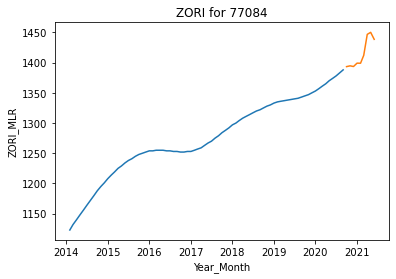

In [775]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual)
sns.lineplot(x = 'Year_Month', y = 'ZORI_MLR', data = pred_MLR)
plt.title(f'ZORI for {zipcode}');

In [776]:
mutual_scores = mutual_info_regression(train.iloc[:, 4:], train.iloc[:, 3])

In [777]:
mutual_score_values = pd.Series(mutual_scores, index = train.iloc[:, 4:].columns).sort_values(ascending = False)
pd.DataFrame(mutual_score_values, columns = ['mutual information scores'])

,mutual information scores
ZORI_lagged_1,2.587809
ZHVI_lagged_1,0.842684
HPI_lagged_2,0.625384
Med_Income_lagged_2,0.623087
CommuteTime_lagged_2,0.456232
Population_lagged_2,0.450117
Total_Households_lagged_2,0.446991
Percent Bachelors_lagged_2,0.415692
Salwrkr_lagged_2,0.378079
Rental Vacancy Rate_lagged_2,0.317929


In [778]:
# Lasso penalization to assess feature significance
scaler = StandardScaler()
data = train.iloc[:, 4:].copy()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data), columns = data.columns)

lasso = Lasso(normalize = True)
alphas = np.linspace(0.001, 0.025, 25)
coefs_lasso  = []

for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(scaled_data, train.iloc[:, 3])  
    coefs_lasso.append(lasso.coef_)

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, 
                           columns = train.iloc[:, 4:].columns)  
coefs_lasso

,ZORI_lagged_1,ZHVI_lagged_1,HPI_lagged_2,AQI_lagged_1,Population_lagged_2,Unemployment_lagged_1,Percent Bachelors_lagged_2,Permits_lagged_1,Total_Households_lagged_2,Med_Income_lagged_2,PCE_lagged_1,Rental Vacancy Rate_lagged_2,Job Openings_lagged_1,CommuteTime_lagged_2,Salwrkr_lagged_2,Govwrkr_lagged_2,GRAPI_lagged_2
0.001,539.484495,5.231816,-1.686606,1.766409,-0.0,4.190989,-0.0,3.494515,-1.633439,-2.809954,0.0,-8.027545,0.000000,-1.474960,-11.445672,-11.797239,6.132431
0.002,538.914430,5.036868,-0.277999,1.399497,-0.0,4.434906,-0.0,3.865812,-0.000000,-1.914234,-0.0,-7.606073,0.308446,-1.545416,-4.224094,-4.725127,5.943104
0.003,538.402916,5.240320,-0.000000,1.551891,0.0,4.154371,-0.0,3.840934,0.000000,-1.548073,-0.0,-7.219416,0.934741,-1.047644,-0.000000,-0.580907,6.121556
0.004,537.648930,5.225842,-0.000000,1.531285,0.0,3.787991,-0.0,3.586424,0.000000,-1.018015,-0.0,-6.655722,1.055682,-0.384835,-0.000000,-0.406327,6.089612
0.005,536.987690,5.172029,-0.000000,1.497615,0.0,3.489742,-0.0,3.343353,0.000000,-0.413632,-0.0,-6.126574,1.205280,-0.000000,-0.000000,-0.210113,6.051751
0.006,536.622537,5.046750,0.000000,1.412121,0.0,3.219616,-0.0,3.075926,0.000000,-0.000000,-0.0,-5.719128,1.380290,-0.000000,-0.000000,-0.000000,5.990902
0.007,536.392910,4.994513,0.000000,1.290426,0.0,2.823669,-0.0,2.722483,0.000000,-0.000000,-0.0,-5.418134,1.529070,-0.000000,-0.000000,-0.000000,5.907137
0.008,536.165347,4.940753,0.000000,1.168741,0.0,2.427528,-0.0,2.367452,0.000000,-0.000000,-0.0,-5.116642,1.678808,-0.000000,-0.000000,-0.000000,5.823685
0.009,535.939926,4.885337,0.000000,1.046988,0.0,2.031086,-0.0,2.010131,0.000000,-0.000000,-0.0,-4.814515,1.830100,-0.000000,-0.000000,-0.000000,5.740667
0.010,535.714533,4.829918,0.000000,0.925255,0.0,1.634670,-0.0,1.652971,0.000000,-0.000000,-0.0,-4.512416,1.981247,-0.000000,-0.000000,-0.000000,5.657622


## Random Forest Regressor on ZORI

In [779]:
randomForest = ensemble.RandomForestRegressor()

In [781]:
grid_para_forest = [{
    "n_estimators": [300],
    "criterion": ["mse"],
    "min_samples_leaf": [50], # [50, 75, 100]
    "min_samples_split": [50], # [50, 75, 100]
    "max_depth": [13], # [11, 12, 13]
    "random_state": [42]}]

grid_search_forest = GridSearchCV(randomForest, grid_para_forest, cv = 5, n_jobs = -1, return_train_score = True)
grid_search_forest.fit(train.iloc[:, 4:], train.iloc[:, 3])

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse'], 'max_depth': [13],
                          'min_samples_leaf': [50], 'min_samples_split': [50],
                          'n_estimators': [300], 'random_state': [42]}],
             return_train_score=True)

In [782]:
pd.DataFrame.from_dict(grid_search_forest.best_params_, orient = 'index', columns = ['hyperparameter'])

,hyperparameter
criterion,mse
max_depth,13
min_samples_leaf,50
min_samples_split,50
n_estimators,300
random_state,42


In [783]:
grid_search_forest.cv_results_['mean_train_score'][0]

0.9959629435285088

In [784]:
grid_search_forest.score(test.iloc[:, 4:], test.iloc[:, 3])

0.9957329357203833

In [282]:
# Refit using the entire dataset
# grid_search_forest.fit(df_clean.iloc[:, 3:], df_clean.iloc[:, 2])

RandomForestRegressor(max_depth=13, min_samples_leaf=50, min_samples_split=50,
                      n_estimators=300, random_state=42)

In [785]:
# Prediction on ZipCode of 77084 (randomly chosen)
zipcode = 77084
df_pred_zipcode = df_pred[df_pred['ZipCode'] == zipcode]
pred_RF = grid_search_forest.predict(df_pred_zipcode.iloc[:, 3:])

In [787]:
pred_RF = pd.DataFrame({'Year': df_pred_zipcode['Year'], 'Month': df_pred_zipcode['Month'], 
                     'ZORI_RF': pred_RF}).reset_index().drop('index', axis = 1)
pred_RF['Year_Month'] = pred_RF['Year'].map(str) + '_' + pred_RF['Month'].map(str)
pred_RF = pred_RF[['Year_Month', 'ZORI_RF']]
pred_RF['Year_Month'] = pd.to_datetime(pred_RF['Year_Month'], format = '%Y_%m')

In [788]:
actual = zori[zori['ZipCode'] == zipcode][['Year_Month', 'ZORI']]
actual['Year_Month'] = pd.to_datetime(actual['Year_Month'], format = '%Y_%m')

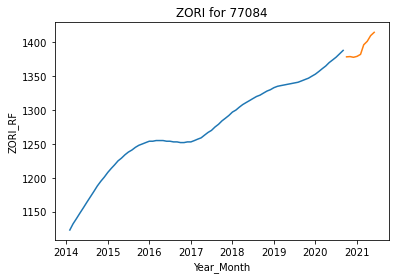

In [789]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual)
sns.lineplot(x = 'Year_Month', y = 'ZORI_RF', data = pred_RF)
plt.title(f'ZORI for {zipcode}');

In [792]:
feature_importance = list(zip(df_pred_zipcode.columns[3:], grid_search_forest.best_estimator_.feature_importances_))
pd.DataFrame(sorted(feature_importance, key = lambda x: x[1], reverse = True), columns = ['feature', 'importance']).head(25)

,feature,importance
0,ZORI_lagged_1,0.997672
1,GRAPI_lagged_2,0.000689
2,Job Openings_lagged_1,0.000315
3,Rental Vacancy Rate_lagged_2,0.000308
4,CommuteTime_lagged_2,0.000109
5,Govwrkr_lagged_2,0.000108
6,ZHVI_lagged_1,0.000104
7,Salwrkr_lagged_2,0.000103
8,Population_lagged_2,0.000102
9,Med_Income_lagged_2,0.000086


## Multiple Linear Regression on % Change in ZORI

In [828]:
# Prepare dataframe for % change fitting
df_change = df.drop('ZORI_lagged_1', axis = 1).copy()
df_change['Year_Month'] = df_change['Year'].map(str) + '_' + df_change['Month'].map(str)
df_change = pd.merge(df_change, one_year_forecast_train, on = 'Year_Month')
df_change = pd.merge(df_change, df_change, left_on = ['Year_Month2', 'ZipCode'], right_on = ['Year_Month', 'ZipCode'],
                     how = 'left')

In [829]:
df_change['ZORI_x'] = (df_change['ZORI_x'] - df_change['ZORI_y']) / df_change['ZORI_y']
df_change['ZHVI_lagged_1_x'] = (df_change['ZHVI_lagged_1_x'] - df_change['ZHVI_lagged_1_y']) / df_change['ZHVI_lagged_1_y']
df_change['HPI_lagged_2_x'] = (df_change['HPI_lagged_2_x'] - df_change['HPI_lagged_2_y']) / df_change['HPI_lagged_2_y']
df_change['AQI_lagged_1_x'] = (df_change['AQI_lagged_1_x'] - df_change['AQI_lagged_1_y']) / df_change['AQI_lagged_1_y']
df_change['Population_lagged_2_x'] = (df_change['Population_lagged_2_x'] - df_change['Population_lagged_2_y']) /\
                                     df_change['Population_lagged_2_y']
df_change['Unemployment_lagged_1_x'] = (df_change['Unemployment_lagged_1_x'] - df_change['Unemployment_lagged_1_y']) /\
                                        df_change['Unemployment_lagged_1_y']
df_change['Percent Bachelors_lagged_2_x'] = (df_change['Percent Bachelors_lagged_2_x'] -\
                                            df_change['Percent Bachelors_lagged_2_y']) /\
                                            df_change['Percent Bachelors_lagged_2_y']
df_change['Permits_lagged_1_x'] = (df_change['Permits_lagged_1_x'] - df_change['Permits_lagged_1_y']) /\
                                  df_change['Permits_lagged_1_y']
df_change['Total_Households_lagged_2_x'] = (df_change['Total_Households_lagged_2_x'] -\
                                           df_change['Total_Households_lagged_2_y']) /\
                                           df_change['Total_Households_lagged_2_y']
df_change['Med_Income_lagged_2_x'] = (df_change['Med_Income_lagged_2_x'] - df_change['Med_Income_lagged_2_y']) /\
                                      df_change['Med_Income_lagged_2_y']
df_change['PCE_lagged_1_x'] = (df_change['PCE_lagged_1_x'] - df_change['PCE_lagged_1_y']) / df_change['PCE_lagged_1_y'] 
df_change['Rental Vacancy Rate_lagged_2_x'] = (df_change['Rental Vacancy Rate_lagged_2_x'] -\
                                              df_change['Rental Vacancy Rate_lagged_2_y']) /\
                                              df_change['Rental Vacancy Rate_lagged_2_y']
df_change['Job Openings_lagged_1_x'] = (df_change['Job Openings_lagged_1_x'] - df_change['Job Openings_lagged_1_y']) /\
                                        df_change['Job Openings_lagged_1_y']
df_change['CommuteTime_lagged_2_x'] = (df_change['CommuteTime_lagged_2_x'] - df_change['CommuteTime_lagged_2_y']) /\
                                        df_change['CommuteTime_lagged_2_y']
df_change['Salwrkr_lagged_2_x'] = (df_change['Salwrkr_lagged_2_x'] - df_change['Salwrkr_lagged_2_y']) /\
                                        df_change['Salwrkr_lagged_2_y']
df_change['Govwrkr_lagged_2_x'] = (df_change['Govwrkr_lagged_2_x'] - df_change['Govwrkr_lagged_2_y']) /\
                                        df_change['Govwrkr_lagged_2_y']
df_change['GRAPI_lagged_2_x'] = (df_change['GRAPI_lagged_2_x'] - df_change['GRAPI_lagged_2_y']) /\
                                        df_change['GRAPI_lagged_2_y']

In [830]:
df_change = df_change[['Year_x', 'Month_x', 'ZipCode', 'ZORI_x', 'ZHVI_lagged_1_x', 'HPI_lagged_2_x', 'AQI_lagged_1_x', 
                      'Population_lagged_2_x', 'Unemployment_lagged_1_x', 'Percent Bachelors_lagged_2_x', 
                      'Permits_lagged_1_x', 'Total_Households_lagged_2_x', 'Med_Income_lagged_2_x', 'PCE_lagged_1_x', 
                      'Rental Vacancy Rate_lagged_2_x', 'Job Openings_lagged_1_x', 'CommuteTime_lagged_2_x', 
                      'Salwrkr_lagged_2_x', 'Govwrkr_lagged_2_x', 'GRAPI_lagged_2_x']]

In [831]:
df_change.columns = ['Year', 'Month', 'ZipCode', 'ZORI_delta', 'ZHVI_lagged_1_delta', 'HPI_lagged_2_delta', 
                     'AQI_lagged_1_delta', 'Population_lagged_2_delta', 'Unemployment_lagged_1_delta',
                     'Percent Bachelors_lagged_2_delta', 'Permits_lagged_1_delta', 'Total_Households_lagged_2_delta',
                     'Med_Income_lagged_2_delta', 'PCE_lagged_1_delta', 'Rental Vacancy Rate_lagged_2_delta',
                     'Job Openings_lagged_1_delta', 'CommuteTime_lagged_2_delta', 'Salwrkr_lagged_2_delta', 
                    'Govwrkr_lagged_2_delta', 'GRAPI_lagged_2_delta']

In [832]:
# ZORI not available for 2013 and Jan 2014
df_change = df_change[(df_change['Year'] != 2014) & ~((df_change['Year'] == 2015) & (df_change['Month'] == 1))]

In [833]:
df_change.isnull().sum(axis = 0)

Year                                      0
Month                                     0
ZipCode                                   0
ZORI_delta                             8666
ZHVI_lagged_1_delta                   17096
HPI_lagged_2_delta                    22958
AQI_lagged_1_delta                    26776
Population_lagged_2_delta             15937
Unemployment_lagged_1_delta           14914
Percent Bachelors_lagged_2_delta      15937
Permits_lagged_1_delta                 9265
Total_Households_lagged_2_delta       15937
Med_Income_lagged_2_delta             15937
PCE_lagged_1_delta                     8666
Rental Vacancy Rate_lagged_2_delta    16282
Job Openings_lagged_1_delta            9871
CommuteTime_lagged_2_delta            15937
Salwrkr_lagged_2_delta                15937
Govwrkr_lagged_2_delta                15937
GRAPI_lagged_2_delta                  15937
dtype: int64

In [834]:
# Dropping NaN values
df_change = df_change[~df_change['ZORI_delta'].isnull()]
df_change = df_change[~df_change['ZHVI_lagged_1_delta'].isnull()]
df_change = df_change[~df_change['HPI_lagged_2_delta'].isnull()]
df_change = df_change[~df_change['AQI_lagged_1_delta'].isnull()]
df_change = df_change[~df_change['Population_lagged_2_delta'].isnull()]
df_change = df_change[~df_change['Permits_lagged_1_delta'].isnull()]
df_change = df_change[~df_change['Rental Vacancy Rate_lagged_2_delta'].isnull()]

In [835]:
df_change.isnull().sum(axis = 0)

Year                                  0
Month                                 0
ZipCode                               0
ZORI_delta                            0
ZHVI_lagged_1_delta                   0
HPI_lagged_2_delta                    0
AQI_lagged_1_delta                    0
Population_lagged_2_delta             0
Unemployment_lagged_1_delta           0
Percent Bachelors_lagged_2_delta      0
Permits_lagged_1_delta                0
Total_Households_lagged_2_delta       0
Med_Income_lagged_2_delta             0
PCE_lagged_1_delta                    0
Rental Vacancy Rate_lagged_2_delta    0
Job Openings_lagged_1_delta           0
CommuteTime_lagged_2_delta            0
Salwrkr_lagged_2_delta                0
Govwrkr_lagged_2_delta                0
GRAPI_lagged_2_delta                  0
dtype: int64

In [836]:
(df_change == np.inf).sum(axis = 0)

Year                                    0
Month                                   0
ZipCode                                 0
ZORI_delta                              0
ZHVI_lagged_1_delta                     0
HPI_lagged_2_delta                      0
AQI_lagged_1_delta                      0
Population_lagged_2_delta               0
Unemployment_lagged_1_delta             0
Percent Bachelors_lagged_2_delta        0
Permits_lagged_1_delta                562
Total_Households_lagged_2_delta         0
Med_Income_lagged_2_delta               0
PCE_lagged_1_delta                      0
Rental Vacancy Rate_lagged_2_delta     55
Job Openings_lagged_1_delta             0
CommuteTime_lagged_2_delta              0
Salwrkr_lagged_2_delta                  0
Govwrkr_lagged_2_delta                  0
GRAPI_lagged_2_delta                    0
dtype: int64

In [837]:
# Drop np.inf values
df_change = df_change[df_change['Permits_lagged_1_delta'] != np.inf]
df_change = df_change[df_change['Rental Vacancy Rate_lagged_2_delta'] != np.inf]

In [838]:
train_change_idx = np.random.choice(range(df_change.shape[0]), round(df_change.shape[0] * 0.75), replace = False)

In [839]:
train_change = df_change.iloc[train_change_idx, :]
test_change = df_change.iloc[list(set(range(df_change.shape[0])) - set(train_change_idx)), :]

In [840]:
# Prepare dataframe for % change prediction
df_pred_change = zori.copy()
df_pred_change = pd.merge(df_pred_change, one_year_forecast_pred, left_on = 'Year_Month', right_on = 'Year_Month2')
df_pred_change.drop('Year_Month_x', axis = 1, inplace = True)

In [841]:
df_pred_change = pd.merge(df_pred_change, zhvi[['Year_Month', 'ZipCode', 'ZHVI']], left_on = ['Year_Month2', 'ZipCode'],
                   right_on = ['Year_Month', 'ZipCode'], how = 'left')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [842]:
df_pred_change = pd.merge(df_pred_change, hpi[['Year_Month', 'ZipCode', 'HPI']], left_on = ['Year_Month3', 'ZipCode'],
                   right_on = ['Year_Month', 'ZipCode'], how = 'left')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [843]:
df_pred_change = pd.merge(df_pred_change, airq[['County', 'State', 'Year_Month', 'AQI']],
                          left_on = ['County', 'State', 'Year_Month2'], right_on = ['County', 'State', 'Year_Month'],
                          how = 'left')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [844]:
df_pred_change = pd.merge(df_pred_change, population[['County', 'State', 'Year_Month', 'Population']], 
                   left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [845]:
df_pred_change = pd.merge(df_pred_change, unemployment[['County', 'State', 'Year_Month', 'Unemployment']], 
                   left_on = ['County', 'State', 'Year_Month2'], right_on = ['County', 'State', 'Year_Month'], how = 'left')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [846]:
df_pred_change = pd.merge(df_pred_change, education[['County', 'State', 'Year_Month', 'Percent Bachelors']],
                          left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'],
                          how = 'left')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [847]:
df_pred_change = pd.merge(df_pred_change, permits[['State', 'Units', 'Year_Month']], left_on = ['State', 'Year_Month2'], 
                          right_on = ['State', 'Year_Month'], how = 'left')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [848]:
df_pred_change = pd.merge(df_pred_change, IandH[['County', 'State', 'Year_Month', 'Total_Households', 'Med_income']], 
                          left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'],
                          how = 'left')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [849]:
df_pred_change = pd.merge(df_pred_change, pce[['PCE', 'Year_Month']], left_on = 'Year_Month2', right_on = 'Year_Month')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [850]:
df_pred_change = pd.merge(df_pred_change, vacancy[['County', 'State', 'Year_Month', 'Rental Vacancy Rate']],
                          left_on = ['County', 'State', 'Year_Month3'], right_on = ['County', 'State', 'Year_Month'],
                          how = 'left')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [851]:
df_pred_change = pd.merge(df_pred_change, jobs[['State', 'Job Openings', 'Year_Month']], left_on = ['State', 'Year_Month2'], 
                          right_on = ['State', 'Year_Month'], how = 'left')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [852]:
df_pred_change = pd.merge(df_pred_change, commute_worker[['County', 'State', 'CommuteTime', 'Salwrkr', 'Govwrkr',
                                                          'Year_Month']],
                          left_on = ['County', 'State', 'Year_Month3'], 
                          right_on = ['County', 'State', 'Year_Month'], how = 'left')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [853]:
df_pred_change = pd.merge(df_pred_change, grapi[['County', 'State', 'GRAPI', 'Year_Month']],
                          left_on = ['County', 'State', 'Year_Month3'], 
                          right_on = ['County', 'State', 'Year_Month'], how = 'left')
df_pred_change.drop('Year_Month', axis = 1, inplace = True)

In [854]:
df_pred_change = df_pred_change[['Year', 'Month', 'ZipCode', 'Year_Month_y', 'Year_Month2', 'Year_Month3', 'ZHVI',
                                 'HPI', 'AQI', 'Population', 'Unemployment', 'Percent Bachelors', 'Units',
                                 'Total_Households', 'Med_income', 'PCE', 'Rental Vacancy Rate', 'Job Openings', 
                                'CommuteTime', 'Salwrkr', 'Govwrkr', 'GRAPI']]
df_pred_change['Year'] = df_pred_change['Year'] + 1

In [856]:
df_temp = df.copy()
df_temp['Year_Month'] = df_temp['Year'].map(str) + '_' + df_temp['Month'].map(str)

In [860]:
df_pred_change = pd.merge(df_pred_change, df_temp, left_on = ['Year_Month2', 'ZipCode'],
                          right_on = ['Year_Month', 'ZipCode'], how = 'left')

In [863]:
df_pred_change['ZHVI'] = (df_pred_change['ZHVI'] - df_pred_change['ZHVI_lagged_1']) / df_pred_change['ZHVI_lagged_1']
df_pred_change['HPI'] = (df_pred_change['HPI'] - df_pred_change['HPI_lagged_2']) / df_pred_change['HPI_lagged_2']
df_pred_change['AQI'] = (df_pred_change['AQI'] - df_pred_change['AQI_lagged_1']) / df_pred_change['AQI_lagged_1']
df_pred_change['Population'] = (df_pred_change['Population'] - df_pred_change['Population_lagged_2']) /\
                                df_pred_change['Population_lagged_2']
df_pred_change['Unemployment'] = (df_pred_change['Unemployment'] - df_pred_change['Unemployment_lagged_1']) /\
                                  df_pred_change['Unemployment_lagged_1']
df_pred_change['Percent Bachelors'] = (df_pred_change['Percent Bachelors'] -\
                                       df_pred_change['Percent Bachelors_lagged_2']) /\
                                       df_pred_change['Percent Bachelors_lagged_2']
df_pred_change['Units'] = (df_pred_change['Units'] - df_pred_change['Permits_lagged_1']) /\
                           df_pred_change['Permits_lagged_1']
df_pred_change['Total_Households'] = (df_pred_change['Total_Households'] -\
                                      df_pred_change['Total_Households_lagged_2']) /\
                                      df_pred_change['Total_Households_lagged_2']
df_pred_change['Med_income'] = (df_pred_change['Med_income'] - df_pred_change['Med_Income_lagged_2']) /\
                                df_pred_change['Med_Income_lagged_2']
df_pred_change['PCE'] = (df_pred_change['PCE'] - df_pred_change['PCE_lagged_1']) / df_pred_change['PCE_lagged_1'] 
df_pred_change['Rental Vacancy Rate'] = (df_pred_change['Rental Vacancy Rate'] -\
                                         df_pred_change['Rental Vacancy Rate_lagged_2']) /\
                                         df_pred_change['Rental Vacancy Rate_lagged_2']
df_pred_change['Job Openings'] = (df_pred_change['Job Openings'] - df_pred_change['Job Openings_lagged_1']) /\
                                  df_pred_change['Job Openings_lagged_1']
df_pred_change['CommuteTime'] = (df_pred_change['CommuteTime'] - df_pred_change['CommuteTime_lagged_2']) /\
                                 df_pred_change['CommuteTime_lagged_2']
df_pred_change['Salwrkr'] = (df_pred_change['Salwrkr'] - df_pred_change['Salwrkr_lagged_2']) /\
                             df_pred_change['Salwrkr_lagged_2']
df_pred_change['Govwrkr'] = (df_pred_change['Govwrkr'] - df_pred_change['Govwrkr_lagged_2']) /\
                             df_pred_change['Govwrkr_lagged_2']
df_pred_change['GRAPI'] = (df_pred_change['GRAPI'] - df_pred_change['GRAPI_lagged_2']) /\
                             df_pred_change['GRAPI_lagged_2']

In [865]:
df_pred_change = df_pred_change[['Year_x', 'Month_x', 'ZipCode', 'ZHVI', 'HPI', 'AQI', 'Population', 'Unemployment',
                                 'Percent Bachelors', 'Units', 'Total_Households', 'Med_income', 'PCE', 
                                 'Rental Vacancy Rate', 'Job Openings', 'CommuteTime', 'Salwrkr', 'Govwrkr', 'GRAPI']]

In [866]:
df_pred_change.columns = ['Year', 'Month', 'ZipCode', 'ZHVI_lagged_1_delta', 'HPI_lagged_2_delta', 'AQI_lagged_1_delta',
                          'Population_lagged_2_delta', 'Unemployment_lagged_1_delta', 'Percent Bachelors_lagged_2_delta',
                          'Permits_lagged_1_delta', 'Total_Households_lagged_2_delta', 'Med_Income_lagged_2_delta',
                          'PCE_lagged_1_delta', 'Rental Vacancy Rate_lagged_2_delta', 'Job Openings_lagged_1_delta', 
                          'CommuteTime_lagged_2_delta', 'Salwrkr_lagged_2_delta', 'Govwrkr_lagged_2_delta', 
                          'GRAPI_lagged_2_delta']

In [867]:
df_pred_change.isnull().sum(axis = 0)

Year                                      0
Month                                     0
ZipCode                                   0
ZHVI_lagged_1_delta                    2742
HPI_lagged_2_delta                     3840
AQI_lagged_1_delta                     4532
Population_lagged_2_delta              2527
Unemployment_lagged_1_delta            2348
Percent Bachelors_lagged_2_delta       2527
Permits_lagged_1_delta                 1244
Total_Households_lagged_2_delta        2527
Med_Income_lagged_2_delta              2527
PCE_lagged_1_delta                     1204
Rental Vacancy Rate_lagged_2_delta     2629
Job Openings_lagged_1_delta           10854
CommuteTime_lagged_2_delta             2527
Salwrkr_lagged_2_delta                 2527
Govwrkr_lagged_2_delta                 2527
GRAPI_lagged_2_delta                   2527
dtype: int64

In [868]:
# Dropping NaN values
df_pred_change = df_pred_change[~df_pred_change['ZHVI_lagged_1_delta'].isnull()]
df_pred_change = df_pred_change[~df_pred_change['HPI_lagged_2_delta'].isnull()]
df_pred_change = df_pred_change[~df_pred_change['AQI_lagged_1_delta'].isnull()]
df_pred_change = df_pred_change[~df_pred_change['Population_lagged_2_delta'].isnull()]
df_pred_change = df_pred_change[~df_pred_change['Permits_lagged_1_delta'].isnull()]
df_pred_change = df_pred_change[~df_pred_change['Rental Vacancy Rate_lagged_2_delta'].isnull()]
df_pred_change = df_pred_change[~df_pred_change['Job Openings_lagged_1_delta'].isnull()]

In [869]:
df_pred_change.isnull().sum(axis = 0)

Year                                  0
Month                                 0
ZipCode                               0
ZHVI_lagged_1_delta                   0
HPI_lagged_2_delta                    0
AQI_lagged_1_delta                    0
Population_lagged_2_delta             0
Unemployment_lagged_1_delta           0
Percent Bachelors_lagged_2_delta      0
Permits_lagged_1_delta                0
Total_Households_lagged_2_delta       0
Med_Income_lagged_2_delta             0
PCE_lagged_1_delta                    0
Rental Vacancy Rate_lagged_2_delta    0
Job Openings_lagged_1_delta           0
CommuteTime_lagged_2_delta            0
Salwrkr_lagged_2_delta                0
Govwrkr_lagged_2_delta                0
GRAPI_lagged_2_delta                  0
dtype: int64

In [870]:
(df_pred_change == np.inf).sum(axis = 0)

Year                                    0
Month                                   0
ZipCode                                 0
ZHVI_lagged_1_delta                     0
HPI_lagged_2_delta                      0
AQI_lagged_1_delta                      0
Population_lagged_2_delta               0
Unemployment_lagged_1_delta             0
Percent Bachelors_lagged_2_delta        0
Permits_lagged_1_delta                107
Total_Households_lagged_2_delta         0
Med_Income_lagged_2_delta               0
PCE_lagged_1_delta                      0
Rental Vacancy Rate_lagged_2_delta     12
Job Openings_lagged_1_delta             0
CommuteTime_lagged_2_delta              0
Salwrkr_lagged_2_delta                  0
Govwrkr_lagged_2_delta                  0
GRAPI_lagged_2_delta                    0
dtype: int64

In [871]:
# Drop np.inf values
df_pred_change = df_pred_change[df_pred_change['Permits_lagged_1_delta'] != np.inf]
df_pred_change = df_pred_change[df_pred_change['Rental Vacancy Rate_lagged_2_delta'] != np.inf]

In [874]:
regression_change = LinearRegression()
regression_change.fit(train_change.iloc[:, 4:], train_change.iloc[:, 3])
regression_change.score(train_change.iloc[:, 4:], train_change.iloc[:, 3])

0.1659310918343544

In [875]:
r2_score(test_change.iloc[:, 3], regression_change.predict(test_change.iloc[:, 4:]))

0.15997574025885142

In [877]:
# Refit using the entire dataset
regression_change.fit(df_change.iloc[:, 4:], df_change.iloc[:, 3])

LinearRegression()

In [878]:
# Prediction on ZipCode of 77084 (randomly chosen)
zipcode = 77084
df_pred_change_zipcode = df_pred_change[df_pred_change['ZipCode'] == zipcode]
pred_change_MLR = regression_change.predict(df_pred_change_zipcode.iloc[:, 3:])

In [879]:
pred_change_MLR = pd.DataFrame({'Year': df_pred_change_zipcode['Year'], 'Month': df_pred_change_zipcode['Month'], 
                     'ZORI_MLR': pred_change_MLR}).reset_index().drop('index', axis = 1)
pred_change_MLR['Year_Month'] = pred_change_MLR['Year'].map(str) + '_' + pred_change_MLR['Month'].map(str)
pred_change_MLR = pred_change_MLR[['Year_Month', 'ZORI_MLR']]
pred_change_MLR['Year_Month'] = pd.to_datetime(pred_change_MLR['Year_Month'], format = '%Y_%m')

In [880]:
actual = zori[zori['ZipCode'] == zipcode][['Year_Month', 'ZORI']]
actual['Year_Month'] = pd.to_datetime(actual['Year_Month'], format = '%Y_%m')

In [881]:
pred_change_MLR.loc[:, 'ZORI_MLR'] = np.array(actual[actual['Year_Month'].isin(pred_change_MLR['Year_Month'].map(lambda date:\
                                     date - relativedelta(months = 12)))]['ZORI']) * np.array((1 +\
                                     pred_change_MLR['ZORI_MLR']))

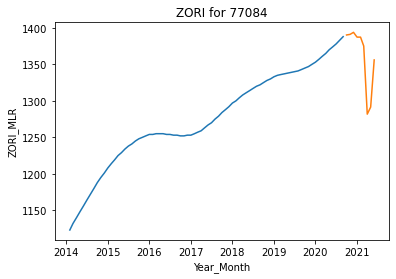

In [882]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual)
sns.lineplot(x = 'Year_Month', y = 'ZORI_MLR', data = pred_change_MLR)
plt.title(f'ZORI for {zipcode}');

In [883]:
mutual_scores_change = mutual_info_regression(train_change.iloc[:, 4:], train_change.iloc[:, 3])

In [884]:
mutual_score_values_change = pd.Series(mutual_scores_change,
                                       index = train_change.iloc[:, 4:].columns).sort_values(ascending = False)
pd.DataFrame(mutual_score_values_change, columns = ['mutual information scores'])

,mutual information scores
Population_lagged_2_delta,0.231083
Total_Households_lagged_2_delta,0.225038
Med_Income_lagged_2_delta,0.220982
CommuteTime_lagged_2_delta,0.219428
Percent Bachelors_lagged_2_delta,0.211946
Salwrkr_lagged_2_delta,0.203188
Rental Vacancy Rate_lagged_2_delta,0.202199
Govwrkr_lagged_2_delta,0.198643
HPI_lagged_2_delta,0.133393
GRAPI_lagged_2_delta,0.098741


## Random Forest Regressor on % Change in ZORI

In [886]:
randomForest_change = ensemble.RandomForestRegressor()

In [887]:
grid_para_forest_change = [{
    "n_estimators": [300],
    "criterion": ["mse"],
    "min_samples_leaf": [50], # [40-60]
    "min_samples_split": [50], # [40-60]
    "max_depth": [11], # [10-12]
    "random_state": [42]}]

grid_search_forest_change = GridSearchCV(randomForest_change, grid_para_forest_change, cv = 5, n_jobs = -1,
                                         return_train_score = True)
grid_search_forest_change.fit(train_change.iloc[:, 4:], train_change.iloc[:, 3])

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse'], 'max_depth': [11],
                          'min_samples_leaf': [50], 'min_samples_split': [50],
                          'n_estimators': [300], 'random_state': [42]}],
             return_train_score=True)

In [888]:
pd.DataFrame.from_dict(grid_search_forest_change.best_params_, orient = 'index', columns = ['hyperparameter'])

,hyperparameter
criterion,mse
max_depth,11
min_samples_leaf,50
min_samples_split,50
n_estimators,300
random_state,42


In [889]:
grid_search_forest_change.cv_results_['mean_train_score'][0]

0.4596050246662339

In [890]:
grid_search_forest_change.score(test_change.iloc[:, 4:], test_change.iloc[:, 3])

0.4277250560285629

In [351]:
# Refit using the entire dataset
# grid_search_forest.fit(df_clean.iloc[:, 3:], df_clean.iloc[:, 2])

In [891]:
# Prediction on ZipCode of 77084 (randomly chosen)
zipcode = 77084
df_pred_change_zipcode = df_pred_change[df_pred_change['ZipCode'] == zipcode]
pred_change_RF = grid_search_forest_change.predict(df_pred_change_zipcode.iloc[:, 3:])

In [893]:
pred_change_RF = pd.DataFrame({'Year': df_pred_change_zipcode['Year'], 'Month': df_pred_change_zipcode['Month'], 
                     'ZORI_RF': pred_change_RF}).reset_index().drop('index', axis = 1)
pred_change_RF['Year_Month'] = pred_change_RF['Year'].map(str) + '_' + pred_change_RF['Month'].map(str)
pred_change_RF = pred_change_RF[['Year_Month', 'ZORI_RF']]
pred_change_RF['Year_Month'] = pd.to_datetime(pred_change_RF['Year_Month'], format = '%Y_%m')

In [894]:
actual = zori[zori['ZipCode'] == zipcode][['Year_Month', 'ZORI']]
actual['Year_Month'] = pd.to_datetime(actual['Year_Month'], format = '%Y_%m')

In [895]:
pred_change_RF.loc[:, 'ZORI_RF'] = np.array(actual[actual['Year_Month'].isin(pred_change_RF['Year_Month'].map(lambda date:\
                                   date - relativedelta(months = 12)))]['ZORI']) * np.array((1 + pred_change_RF['ZORI_RF']))

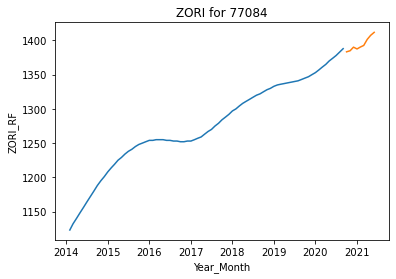

In [896]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual)
sns.lineplot(x = 'Year_Month', y = 'ZORI_RF', data = pred_change_RF)
plt.title(f'ZORI for {zipcode}');

## Aggregate Prediction

In [897]:
pred = pd.DataFrame({'Year_Month': pred_MLR['Year_Month'], 'ZORI':\
            ((pred_MLR['ZORI_MLR'] + pred_RF['ZORI_RF'] + pred_change_MLR['ZORI_MLR'] + pred_change_RF['ZORI_RF']) / 4)})

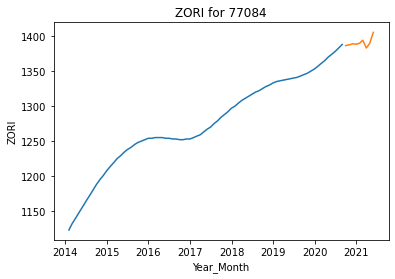

In [898]:
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = actual)
sns.lineplot(x = 'Year_Month', y = 'ZORI', data = pred)
plt.title(f'ZORI for {zipcode}');